Processing 1223 valid movie entries...
Welcome to the Movie Recommendation System!
MOVIE RECOMMENDATION SYSTEM
1. Get Movie Recommendations
2. Show Dataset Analytics
3. K-Means Clustering Analysis
4. Compare Two Movies
5. Movie Discovery Engine
6. Exit

Enter your choice (1-6): 1

Enter your favorite movie name: avatar
How many recommendations? (default 10): 10

Searching for 'avatar' using HYBRID algorithm...

HYBRID RECOMMENDATION RESULTS
Based on: Avatar

Original Movie Details:
   Genres: action, adventure, fantasy, science fiction...
   Rating: 8.0/10
   Cluster: 7

Top 10 Recommendations:

 1. HIGH Avatar: The Way of Water
      2022 | 8.0/10 | Score: 0.524
      action, adventure, science fiction...
      Cluster: 7

 2. HIGH Predator: Badlands
      2025 | 8.0/10 | Score: 0.442
      action, science fiction, adventure...
      Cluster: 7

 3. HIGH David Attenborough: A Life on Our Planet
      2020 | 8.0/10 | Score: 0.425
      documentary, drama...
      Cluster: 7

 4. HIGH F

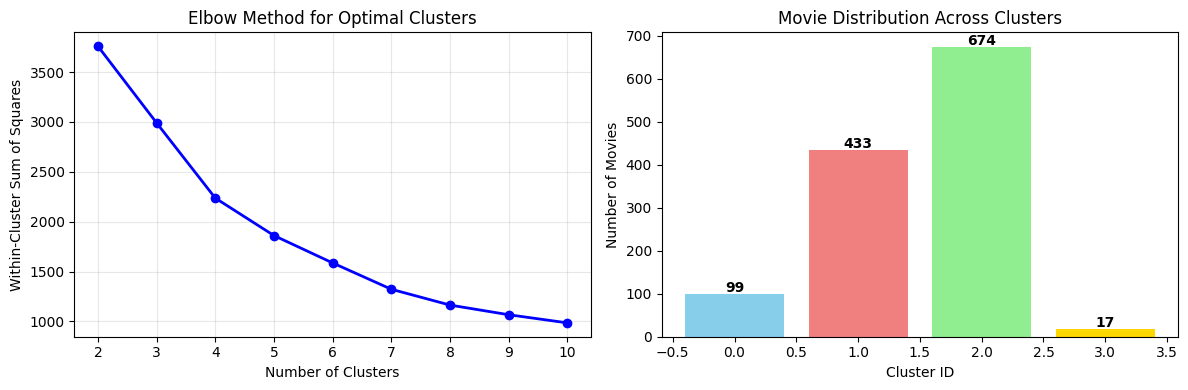


CLUSTER ANALYSIS RESULTS (4 clusters):

CLUSTER 0:
   Size: 99 movies
   Average Rating: 7.8/10
   Average Popularity: 5.8
   Top Genres: drama, comedy, romance
   Sample Movies: Beach House, Sea Fever, Busy Bodies

CLUSTER 1:
   Size: 433 movies
   Average Rating: 4.2/10
   Average Popularity: 25.7
   Top Genres: drama, thriller, comedy
   Sample Movies: Avatar: Fire and Ash, Abraham's Boys: A Dracula Story, Heads of State

CLUSTER 2:
   Size: 674 movies
   Average Rating: 8.0/10
   Average Popularity: 13.5
   Top Genres: drama, adventure, action
   Sample Movies: The Family Plan, Prisoner of War, Harry Potter and the Philosopher's Stone

CLUSTER 3:
   Size: 17 movies
   Average Rating: 4.5/10
   Average Popularity: 202.4
   Top Genres: action, thriller, adventure
   Sample Movies: Aquaman, Operation Blood Hunt, JUJUTSU KAISEN: Execution -Shibuya Incident x The Culling Game Begins-
MOVIE RECOMMENDATION SYSTEM
1. Get Movie Recommendations
2. Show Dataset Analytics
3. K-Means Clusterin

In [ ]:
import numpy as np
import pandas as pd
import difflib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
import re
warnings.filterwarnings('ignore')

class MovieRecommender:
    def __init__(self, data_path):
        self.movies_data = pd.read_csv(data_path)
        self.setup_data()
        self.build_recommendation_engine()
        self.build_advanced_features()

    def setup_data(self):
        if 'index' not in self.movies_data.columns:
            self.movies_data.reset_index(inplace=True)
            self.movies_data.rename(columns={'index': 'original_index'}, inplace=True)
            self.movies_data['index'] = range(len(self.movies_data))

        # Enhanced rating data cleaning
        if 'vote_average' in self.movies_data.columns:
            rating_mapping = {
                'Low': 2.0,
                'Medium': 5.0,
                'High': 8.0,
                'Unknown': 0.0
            }
            self.movies_data['vote_average'] = self.movies_data['vote_average'].apply(
                lambda x: rating_mapping.get(x, x) if isinstance(x, str) else x
            )

            self.movies_data['vote_average'] = pd.to_numeric(self.movies_data['vote_average'], errors='coerce')
            self.movies_data['vote_average'].fillna(0, inplace=True)

            # Check if ratings need rescaling
            if self.movies_data['vote_average'].max() > 10 or self.movies_data['vote_average'].min() < 0:
                current_min = self.movies_data['vote_average'].min()
                current_max = self.movies_data['vote_average'].max()

                if current_max > current_min:
                    self.movies_data['vote_average'] = (
                        (self.movies_data['vote_average'] - current_min) /
                        (current_max - current_min) * 10
                    )
                else:
                    self.movies_data['vote_average'] = 5.0
            elif self.movies_data['vote_average'].max() <= 1.0 and self.movies_data['vote_average'].min() >= -1.0 and self.movies_data['vote_average'].max() > 0:
                self.movies_data['vote_average'] = self.movies_data['vote_average'] * 10

        # Enhanced popularity data cleaning
        if 'popularity' in self.movies_data.columns:
            if self.movies_data['popularity'].max() > 1000:
                self.movies_data['popularity_log'] = np.log1p(self.movies_data['popularity'])
                pop_99th = self.movies_data['popularity'].quantile(0.99)
                self.movies_data['popularity_capped'] = np.where(
                    self.movies_data['popularity'] > pop_99th,
                    pop_99th,
                    self.movies_data['popularity']
                )

        text_columns = ['genres', 'keywords', 'tagline', 'overview', 'cast', 'director']
        for col in text_columns:
            if col in self.movies_data.columns:
                self.movies_data[col] = self.movies_data[col].fillna('')
            else:
                self.movies_data[col] = ''
        self.movies_data['release_date'] = pd.to_datetime(self.movies_data['release_date'], errors='coerce')
        self.movies_data['release_year'] = self.movies_data['release_date'].dt.year
        self.fix_release_years()
        numeric_columns = ['budget', 'revenue', 'vote_average', 'vote_count', 'runtime']
        for col in numeric_columns:
            if col in self.movies_data.columns:
                self.movies_data[col] = pd.to_numeric(self.movies_data[col], errors='coerce').fillna(0)

        # Calculate additional metrics
        self.movies_data['profit'] = self.movies_data['revenue'] - self.movies_data['budget']
        self.movies_data['roi'] = np.where(
            self.movies_data['budget'] > 0,
            (self.movies_data['profit'] / self.movies_data['budget']) * 100, 0
        )

        # Success Category Labels
        self.movies_data['success_category'] = self.movies_data['roi'].apply(
            lambda x:
                "Flop" if x < 0 else
                "Average" if 0 <= x < 50 else
                "Hit" if 50 <= x < 200 else
                "Super Hit"
        )

    def fix_release_years(self):
        fixed_count = 0
        for idx, movie in self.movies_data.iterrows():
            current_year = self.movies_data.at[idx, 'release_year']

            # If year is missing or invalid, try to fix it
            if pd.isna(current_year) or current_year == 0 or current_year == "N/A" or current_year == "NaN":
                fixed_year = self._extract_release_year(movie)
                if fixed_year and fixed_year > 1900 and fixed_year < 2030:
                    self.movies_data.at[idx, 'release_year'] = fixed_year
                    fixed_count += 1

        if fixed_count > 0:
            print(f"Fixed {fixed_count} missing release years")

    def _extract_release_year(self, movie):
        if 'release_date' in movie and pd.notna(movie['release_date']):
            try:
                date_obj = pd.to_datetime(movie['release_date'], errors='coerce')
                if pd.notna(date_obj):
                    year = date_obj.year
                    if 1900 < year < 2030:
                        return year
            except:
                pass
        if 'title' in movie and pd.notna(movie['title']):
            title = str(movie['title'])
            year_match = re.search(r'\((\d{4})\)$', title)
            if year_match:
                try:
                    year = int(year_match.group(1))
                    if 1900 < year < 2030:
                        return year
                except:
                    pass

        return None

    def build_recommendation_engine(self):
        selected_features = ['genres', 'keywords', 'tagline', 'overview', 'director']
        for feature in selected_features:
            if feature not in self.movies_data.columns:
                self.movies_data[feature] = ''
            self.movies_data[feature] = self.movies_data[feature].astype(str).str.lower()

        combined_features = (
            self.movies_data['genres'] + ' ' +
            self.movies_data['keywords'] + ' ' +
            self.movies_data['tagline'] + ' ' +
            self.movies_data['overview'] + ' ' +
            self.movies_data['director']
        )
        combined_features = combined_features.fillna('').astype(str)

        valid_indices = combined_features != 'nan'
        self.movies_data = self.movies_data[valid_indices].copy()
        combined_features = combined_features[valid_indices]

        print(f"Processing {len(combined_features)} valid movie entries...")

        try:
            self.vectorizer = TfidfVectorizer(
                stop_words='english',
                max_features=5000,
                min_df=2,
                max_df=0.8
            )
            feature_vectors = self.vectorizer.fit_transform(combined_features)
            self.similarity = cosine_similarity(feature_vectors)
        except Exception as e:
            n_movies = len(self.movies_data)
            self.similarity = np.eye(n_movies)

    def build_advanced_features(self):
        try:
            # Enhanced content-based features
            self.movies_data['enhanced_features'] = (
                self.movies_data['genres'] + ' ' +
                self.movies_data['keywords'] + ' ' +
                self.movies_data['director'] + ' ' +
                self.movies_data['cast'].astype(str).str.split(',').str[0] + ' ' +
                self.movies_data['tagline']
            )

            self.enhanced_vectorizer = TfidfVectorizer(
                stop_words='english',
                max_features=8000,
                ngram_range=(1, 2),
                min_df=3,
                max_df=0.9
            )

            enhanced_vectors = self.enhanced_vectorizer.fit_transform(
                self.movies_data['enhanced_features'].fillna('')
            )

            self.cosine_sim_enhanced = cosine_similarity(enhanced_vectors)

            n_components = min(50, self.cosine_sim_enhanced.shape[0] - 1)
            self.svd = TruncatedSVD(n_components=n_components, random_state=42)
            self.svd_features = self.svd.fit_transform(self.cosine_sim_enhanced)

            # Clustering
            n_clusters = min(8, len(self.svd_features) // 20)
            if n_clusters >= 2:
                self.kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
                self.movies_data['cluster'] = self.kmeans.fit_predict(self.svd_features)

            # Hybrid weights
            self.hybrid_weights = {
                'content_similarity': 0.6,
                'rating_score': 0.2,
                'popularity': 0.1,
                'recency': 0.1
            }

        except Exception as e:
            print(f"Some advanced features couldn't be built: {e}")

    # MAIN MENU AND INTERFACE
    def show_menu(self):
        print("MOVIE RECOMMENDATION SYSTEM")
        print("1. Get Movie Recommendations")
        print("2. Show Dataset Analytics")
        print("3. K-Means Clustering Analysis")
        print("4. Compare Two Movies")
        print("5. Movie Discovery Engine")
        print("6. Exit")

    def interactive_system(self):
        print("Welcome to the Movie Recommendation System!")

        while True:
            self.show_menu()
            choice = input("\nEnter your choice (1-6): ").strip()

            if choice == '1':
                self._handle_recommendations()
            elif choice == '2':
                self.show_movie_analytics()
            elif choice == '3':
                self.analyze_movie_clusters()
            elif choice == '4':
                self.compare_two_movies()
            elif choice == '5':
                self._handle_movie_discovery()
            elif choice == '6':
                print("\nThank you for using the Movie Recommendation System!")
                print("Happy movie watching!")
                break
            else:
                print("Invalid choice. Please try again.")

    def _handle_recommendations(self):
        movie_name = input("\nEnter your favorite movie name: ").strip()
        if not movie_name:
            print("Please enter a movie name.")
            return

        n_recs = input("How many recommendations? (default 10): ").strip()
        try:
            n_recommendations = int(n_recs) if n_recs else 10
        except ValueError:
            n_recommendations = 10

        self.display_advanced_recommendations(movie_name, n_recommendations, 'hybrid')

    # MOVIE DISCOVERY ENGINE
    def _handle_movie_discovery(self):
        print("\nMOVIE DISCOVERY ENGINE")
        print("1. Recent Hits")
        print("2. Genre Deep Dive")
        print("3. Director Spotlight")
        print("4. Time Machine (By decade)")

        choice = input("\nChoose discovery method (1-4): ").strip()

        if choice == '1':
            self.discover_recent_hits()
        elif choice == '2':
            self.genre_deep_dive()
        elif choice == '3':
            self.director_spotlight()
        elif choice == '4':
            self.time_machine_decades()
        else:
            print("Invalid choice")

    def discover_recent_hits(self):
        print("\nDISCOVERING RECENT HITS...")

        current_year = pd.Timestamp.now().year
        recent_movies = self.movies_data[
            (self.movies_data['release_year'] >= current_year - 5) &
            (self.movies_data['vote_average'] >= 7.0) &
            (self.movies_data['vote_count'] >= 100)
        ].sort_values(['vote_average', 'popularity'], ascending=[False, False]).head(15)

        if recent_movies.empty:
            print("No recent hits found.")
            return

        print(f"Top {len(recent_movies)} Recent Hits (Last 5 years, rating >=7.0):\n")

        for i, (_, movie) in enumerate(recent_movies.iterrows(), 1):
            print(f"{i}. {movie['vote_average']:.1f} | {self._get_release_year(movie)} | {movie['title']}")
            print(f"   {movie['genres'][:60]}...\n")

    def genre_deep_dive(self):
        print("\nGENRE DEEP DIVE")

        # Get all unique genres
        all_genres = []
        for genres in self.movies_data['genres'].dropna():
            if isinstance(genres, str):
                clean_genres = genres.replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace('"', '')
                genre_list = [genre.strip() for genre in clean_genres.split(',') if genre.strip()]
                all_genres.extend(genre_list)

        unique_genres = sorted(set(all_genres))

        print("Available genres:")
        for i, genre in enumerate(unique_genres[:15], 1):
            print(f"{i}. {genre}")

        try:
            choice = int(input(f"\nChoose a genre (1-{len(unique_genres[:15])}): "))
            if 1 <= choice <= len(unique_genres[:15]):
                selected_genre = unique_genres[choice-1]
                self._show_genre_recommendations(selected_genre)
            else:
                print("Invalid choice")
        except ValueError:
            print("Please enter a valid number")

    def _show_genre_recommendations(self, genre):
        print(f"\nTOP {genre.upper()} MOVIES")

        genre_movies = self.movies_data[
            self.movies_data['genres'].str.contains(genre, na=False)
        ].sort_values('vote_average', ascending=False).head(10)

        if genre_movies.empty:
            print(f"No movies found for genre: {genre}")
            return

        print(f"Found {len(genre_movies)} highly-rated {genre} movies:\n")

        for i, (_, movie) in enumerate(genre_movies.iterrows(), 1):
            print(f"{i}. {movie['vote_average']:.1f} | {movie['title']}")
            if 'director' in movie and pd.notna(movie['director']):
                print(f"   Director: {movie['director'][:40]}")

    def director_spotlight(self):
        print("\nDIRECTOR SPOTLIGHT")

        # Get top directors (with most movies)
        director_movies = self.movies_data['director'].value_counts().head(15)

        print("Popular directors:")
        for i, (director, count) in enumerate(director_movies.items(), 1):
            print(f"{i}. {director} ({count} movies)")

        print("\n16. Search for a specific director")

        try:
            choice = input("Choose a director (1-16): ").strip()

            if choice == '16':
                director_name = input("Enter director name: ").strip()
                self._show_director_filmography(director_name)
            else:
                choice = int(choice)
                if 1 <= choice <= 15:
                    selected_director = director_movies.index[choice-1]
                    self._show_director_filmography(selected_director)
                else:
                    print("Invalid choice")
        except (ValueError, IndexError):
            print("Please enter a valid number")

    def _show_director_filmography(self, director_name):
        print(f"\n{director_name.upper()} - FILMOGRAPHY")

        director_movies = self.movies_data[
            self.movies_data['director'] == director_name
        ].sort_values('release_year', ascending=False)

        if director_movies.empty:
            print(f"No movies found for director: {director_name}")
            # Try fuzzy matching
            all_directors = self.movies_data['director'].dropna().unique()
            matches = difflib.get_close_matches(director_name, all_directors, n=3, cutoff=0.6)
            if matches:
                print(f"Did you mean: {', '.join(matches)}?")
            return

        print(f"Found {len(director_movies)} movies by {director_name}:\n")

        for i, (_, movie) in enumerate(director_movies.iterrows(), 1):
            print(f"{i}. {movie['vote_average']:.1f} | {movie['title']}")
            print(f"   {movie['genres'][:60]}...")
            if movie['revenue'] > 0:
                print(f"   Revenue: ${movie['revenue']:,.0f}\n")
            else:
                print()

    def time_machine_decades(self):
        print("\nTIME MACHINE, EXPLORE BY DECADE")

        decades = {
            '1': (2020, 2029, "2020s (Current)"),
            '2': (2010, 2019, "2010s"),
            '3': (2000, 2009, "2000s"),
            '4': (1990, 1999, "1990s"),
            '5': (1980, 1989, "1980s"),
            '6': (1970, 1979, "1970s"),
            '7': (1960, 1969, "1960s"),
            '8': (1950, 1959, "1950s"),
            '9': (1940, 1949, "1940s"),
            '10': (1920, 1939, "1920s-1930s (Classic)")
        }

        for key, (start, end, label) in decades.items():
            print(f"{key}. {label}")

        choice = input("\nChoose a decade (1-10): ").strip()

        if choice in decades:
            start_year, end_year, label = decades[choice]
            self._show_decade_movies(start_year, end_year, label)
        else:
            print("Invalid choice")

    def _show_decade_movies(self, start_year, end_year, label):
        print(f"\nTOP MOVIES FROM THE {label.upper()}")

        decade_movies = self.movies_data[
            (self.movies_data['release_year'] >= start_year) &
            (self.movies_data['release_year'] <= end_year) &
            (self.movies_data['vote_count'] >= 50)
        ].sort_values('vote_average', ascending=False).head(15)

        if decade_movies.empty:
            print(f"No movies found from {start_year}-{end_year}")
            return

        print(f"Top {len(decade_movies)} rated movies from {start_year}-{end_year}:\n")

        for i, (_, movie) in enumerate(decade_movies.iterrows(), 1):
            print(f"{i}. {movie['vote_average']:.1f} | {movie['title']}")
            print(f"   {movie['genres'][:60]}...")
            if 'director' in movie and pd.notna(movie['director']):
                print(f"   {movie['director']}\n")

    def _get_release_year(self, movie):
        if 'release_year' in movie and pd.notna(movie['release_year']):
            try:
                year = int(movie['release_year'])
                if 1900 < year < 2030:
                    return str(year)
            except (ValueError, TypeError):
                pass

        if 'release_date' in movie and pd.notna(movie['release_date']):
            try:
                if isinstance(movie['release_date'], str):
                    date_str = str(movie['release_date']).strip()
                    for fmt in ['%Y-%m-%d', '%m/%d/%Y', '%d/%m/%Y', '%Y']:
                        try:
                            date_obj = pd.to_datetime(date_str, format=fmt, errors='coerce')
                            if pd.notna(date_obj):
                                year = date_obj.year
                                if 1900 < year < 2030:
                                    return str(year)
                        except:
                            continue
                else:
                    year = movie['release_date'].year
                    if 1900 < year < 2030:
                        return str(year)
            except (ValueError, TypeError, AttributeError):
                pass

        if 'title' in movie and pd.notna(movie['title']):
            title = str(movie['title'])
            year_match = re.search(r'\((\d{4})\)$', title)
            if year_match:
                try:
                    year = int(year_match.group(1))
                    if 1900 < year < 2030:
                        return str(year)
                except (ValueError, TypeError):
                    pass

        if 'release_date' in movie and pd.notna(movie['release_date']):
            try:
                date_obj = pd.to_datetime(movie['release_date'], errors='coerce')
                if pd.notna(date_obj):
                    year = date_obj.year
                    if 1900 < year < 2030:
                        return str(year)
            except:
                pass

        if 'year' in movie and pd.notna(movie['year']):
            try:
                year = int(movie['year'])
                if 1900 < year < 2030:
                    return str(year)
            except (ValueError, TypeError):
                pass

        return "N/A"

    def show_movie_analytics(self):
        print("\nCOMPREHENSIVE MOVIE DATASET ANALYTICS")

        # First, let's diagnose the data issues
        print("\nDATA DIAGNOSTICS:")
        print(f"Total movies: {len(self.movies_data)}")

        # Check rating data
        rating_data = self.movies_data['vote_average'].dropna()
        if len(rating_data) == 0:
            print("No rating data available for analysis")
            return

        print(f"Movies with ratings: {len(rating_data)}")
        print(f"Rating range: {rating_data.min():.1f} - {rating_data.max():.1f}")
        print(f"Average rating: {rating_data.mean():.2f}/10")

        # Check for zero ratings
        zero_ratings = (self.movies_data['vote_average'] == 0).sum()
        print(f"Movies with 0 rating: {zero_ratings} ({zero_ratings/len(self.movies_data)*100:.1f}%)")

        # 1. FIXED RATING DISTRIBUTION
        print("\nRATING DISTRIBUTION")
        plt.figure(figsize=(12, 5))

        # Filter out zero ratings for better visualization
        non_zero_ratings = rating_data[rating_data > 0]

        plt.subplot(1, 2, 1)
        plt.hist(non_zero_ratings, bins=20, color='royalblue', alpha=0.7, edgecolor='black')
        plt.title('Distribution of Movie Ratings\n(Excluding zeros)')
        plt.xlabel('Rating (out of 10)')
        plt.ylabel('Number of Movies')
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.boxplot(non_zero_ratings, vert=False, patch_artist=True)
        plt.title('Rating Distribution\n(Excluding zeros)')
        plt.xlabel('Rating')

        plt.tight_layout()
        plt.show()

        Q1 = non_zero_ratings.quantile(0.25)
        Q3 = non_zero_ratings.quantile(0.75)
        IQR = Q3 - Q1
        print(f"Average Rating: {non_zero_ratings.mean():.2f}/10")
        print(f"Rating Range: {non_zero_ratings.min():.1f} - {non_zero_ratings.max():.1f}")
        print(f"IQR: {Q1:.1f} - {Q3:.1f}")

        # 2. FIXED POPULARITY vs RATING
        if 'popularity' in self.movies_data.columns and 'vote_count' in self.movies_data.columns:
            print("\nPOPULARITY vs RATING ANALYSIS")

            # Use the best available popularity metric
            if 'popularity_capped' in self.movies_data.columns:
                pop_col = 'popularity_capped'
            elif 'popularity_log' in self.movies_data.columns:
                pop_col = 'popularity_log'
            else:
                pop_col = 'popularity'

            # Filter data for better visualization
            plot_data = self.movies_data[
                (self.movies_data['vote_average'] > 0) &
                (self.movies_data[pop_col] > 0)
            ].copy()

            if len(plot_data) > 0:
                plt.figure(figsize=(10, 6))

                # Sample data to avoid overplotting
                sample_data = plot_data.sample(min(1000, len(plot_data)))

                scatter = plt.scatter(
                    sample_data[pop_col],
                    sample_data['vote_average'],
                    c=sample_data['vote_count'],
                    cmap='viridis',
                    alpha=0.6,
                    s=50
                )
                plt.colorbar(scatter, label='Vote Count')
                plt.title('Popularity vs Rating')
                plt.xlabel(f'Popularity ({pop_col.replace("_", " ").title()})')
                plt.ylabel('Rating (out of 10)')
                plt.ylim(0, 10)

                # Add correlation info
                pop_rating_corr = plot_data[pop_col].corr(plot_data['vote_average'])
                plt.text(0.05, 0.95, f'Correlation: {pop_rating_corr:.2f}',
                        transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

                plt.tight_layout()
                plt.show()

                print(f"Popularity-Rating Correlation: {pop_rating_corr:.3f}")
            else:
                print("Not enough data for popularity vs rating analysis")

        # 3. CORRELATION MATRIX (This was already good)
        print("\nFEATURE CORRELATION MATRIX")

        correlation_data = self.movies_data[['vote_average']].copy()

        if 'vote_count' in self.movies_data.columns:
            correlation_data['vote_count'] = np.log1p(self.movies_data['vote_count'])

        # Use the best popularity metric
        if 'popularity_log' in self.movies_data.columns:
            correlation_data['popularity'] = self.movies_data['popularity_log']
        elif 'popularity_capped' in self.movies_data.columns:
            correlation_data['popularity'] = self.movies_data['popularity_capped']
        elif 'popularity' in self.movies_data.columns:
            correlation_data['popularity'] = self.movies_data['popularity']

        if 'runtime' in self.movies_data.columns:
            correlation_data['runtime'] = self.movies_data['runtime']

        if 'budget' in self.movies_data.columns:
            correlation_data['budget'] = np.log1p(self.movies_data['budget'].replace(0, np.nan))

        if 'revenue' in self.movies_data.columns:
            correlation_data['revenue'] = np.log1p(self.movies_data['revenue'].replace(0, np.nan))

        correlation_data_clean = correlation_data.dropna()

        if len(correlation_data_clean) > 10:
            corr_matrix = correlation_data_clean.corr()

            plt.figure(figsize=(10, 8))
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

            sns.heatmap(
                corr_matrix,
                mask=mask,
                annot=True,
                cmap='RdBu_r',
                center=0,
                fmt=".2f",
                linewidths=0.5,
                square=True,
                cbar_kws={"shrink": 0.8}
            )

            plt.title('Movie Features Correlation Matrix\n(Optimized for Analysis)', fontsize=14, pad=20)
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()

            print("Key Correlation Insights:")
            if 'budget' in corr_matrix.columns and 'revenue' in corr_matrix.columns:
                budget_revenue_corr = corr_matrix.loc['budget', 'revenue']
                expected = "LOW" if budget_revenue_corr < 0.3 else "GOOD" if budget_revenue_corr > 0.5 else "MODERATE"
                print(f"   Budget vs Revenue: {budget_revenue_corr:.3f} {expected}")

            if 'vote_average' in corr_matrix.columns and 'vote_count' in corr_matrix.columns:
                rating_votes_corr = corr_matrix.loc['vote_average', 'vote_count']
                expected = "NORMAL" if 0.1 <= rating_votes_corr <= 0.3 else "UNUSUAL"
                print(f"   Rating vs Vote Count: {rating_votes_corr:.3f} {expected}")

            if 'popularity' in corr_matrix.columns and 'revenue' in corr_matrix.columns:
                pop_revenue_corr = corr_matrix.loc['popularity', 'revenue']
                expected = "STRONG" if pop_revenue_corr > 0.5 else "MODERATE" if pop_revenue_corr > 0.3 else "WEAK"
                print(f"   Popularity vs Revenue: {pop_revenue_corr:.3f} {expected}")

            print(f"   Based on {len(correlation_data_clean)} high-quality data points")
        else:
            print("Not enough quality data for correlation analysis")

        # 4. GENRE ANALYSIS (This was already good)
        print("\nGENRE ANALYSIS")

        all_genres = []
        for genres in self.movies_data['genres'].dropna():
            if isinstance(genres, str):
                clean_genres = genres.replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace('"', '')
                genre_list = [genre.strip() for genre in clean_genres.split(',') if genre.strip()]
                all_genres.extend(genre_list)

        if all_genres:
            genre_counts = pd.Series(all_genres).value_counts().head(10)
            plt.figure(figsize=(14, 6))

            # Plot 1: Most Common Genres
            plt.subplot(1, 2, 1)
            bars = sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
            plt.title('Top 10 Most Common Genres', fontweight='bold')
            plt.xlabel('Number of Movies')
            for i, v in enumerate(genre_counts.values):
                bars.text(v + 5, i, f'{v}', va='center', fontweight='bold')

            # Plot 2: Average Rating by Genre
            plt.subplot(1, 2, 2)
            genre_ratings = {}
            genre_movie_counts = {}

            for genre in genre_counts.index:
                genre_movies = self.movies_data[
                    (self.movies_data['genres'].str.contains(genre, na=False)) &
                    (self.movies_data['vote_average'] > 2.0)
                ]
                if len(genre_movies) > 5:
                    genre_ratings[genre] = genre_movies['vote_average'].mean()
                    genre_movie_counts[genre] = len(genre_movies)

            if genre_ratings:
                genre_ratings_series = pd.Series(genre_ratings).sort_values(ascending=False)
                bars = sns.barplot(x=genre_ratings_series.values, y=genre_ratings_series.index, palette='RdYlBu')
                plt.title('Average Rating by Genre\n(Filtered: rating > 2.0, min 5 movies)', fontweight='bold')
                plt.xlabel('Average Rating (out of 10)')
                plt.xlim(0, 10)

                for i, (genre, rating) in enumerate(genre_ratings_series.items()):
                    count = genre_movie_counts[genre]
                    bars.text(rating + 0.1, i, f'{rating:.1f}\n(n={count})', va='center', fontsize=9)
            else:
                plt.text(0.5, 0.5, 'Not enough rating data\nfor genre analysis',
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title('Average Rating by Genre\n(Insufficient Data)')

            plt.tight_layout()
            plt.show()

            print("Genre Rating Summary:")
            for genre in genre_counts.index[:5]:
                if genre in genre_ratings:
                    print(f"   {genre}: {genre_ratings[genre]:.1f}/10")

        # Top & Bottom Movies
        print("TOP 5 HIGHEST RATED MOVIES (min 100 votes):")
        top_rated = self.movies_data[self.movies_data['vote_count'] >= 100].nlargest(5, 'vote_average')
        for i, (_, movie) in enumerate(top_rated.iterrows(), 1):
            print(f"   {i}. {movie['title']}: {movie['vote_average']:.1f}/10")

        print("\nTOP 5 MOST POPULAR MOVIES:")
        if 'popularity_capped' in self.movies_data.columns:
            top_popular = self.movies_data.nlargest(5, 'popularity_capped')
            popularity_col = 'popularity_capped'
        else:
            top_popular = self.movies_data.nlargest(5, 'popularity')
            popularity_col = 'popularity'

        for i, (_, movie) in enumerate(top_popular.iterrows(), 1):
            print(f"   {i}. {movie['title']}: Popularity {movie[popularity_col]:.1f}")

        # 5. FIXED RUNTIME ANALYSIS
        if 'runtime' in self.movies_data.columns:
            print("\nRUNTIME DISTRIBUTION")

            runtime_data = self.movies_data['runtime'].dropna()
            print(f"Runtime statistics:")
            print(f"   Total movies with runtime data: {len(runtime_data)}")
            print(f"   Runtime range: {runtime_data.min():.0f} - {runtime_data.max():.0f} minutes")
            print(f"   Average runtime: {runtime_data.mean():.1f} minutes")

            # Filter for reasonable runtimes (30-240 minutes)
            reasonable_runtime = self.movies_data[
                (self.movies_data['runtime'] >= 30) &
                (self.movies_data['runtime'] <= 240) &
                (self.movies_data['vote_average'] > 0)
            ]

            if len(reasonable_runtime) > 50:
                plt.figure(figsize=(14, 5))

                # Plot 1: Runtime Distribution
                plt.subplot(1, 2, 1)
                plt.hist(reasonable_runtime['runtime'], bins=30, color='green', alpha=0.7, edgecolor='black')
                plt.title('Distribution of Movie Runtimes\n(30-240 minutes)', fontweight='bold')
                plt.xlabel('Runtime (minutes)')
                plt.ylabel('Number of Movies')
                avg_runtime = reasonable_runtime['runtime'].mean()
                plt.axvline(avg_runtime, color='red', linestyle='--', alpha=0.8,
                           label=f'Average: {avg_runtime:.0f} min')
                plt.legend()
                plt.grid(True, alpha=0.3)

                # Plot 2: Runtime vs Rating
                plt.subplot(1, 2, 2)
                sample_data = reasonable_runtime.sample(min(500, len(reasonable_runtime)))
                plt.scatter(sample_data['runtime'], sample_data['vote_average'],
                           alpha=0.6, color='purple', s=30)
                plt.title('Runtime vs Rating\n(Filtered: 30-240 minutes)', fontweight='bold')
                plt.xlabel('Runtime (minutes)')
                plt.ylabel('Rating (out of 10)')
                plt.ylim(0, 10)
                plt.xlim(30, 240)
                plt.grid(True, alpha=0.3)

                # Add trend line
                if len(sample_data) > 10:
                    z = np.polyfit(sample_data['runtime'], sample_data['vote_average'], 1)
                    p = np.poly1d(z)
                    plt.plot(sample_data['runtime'], p(sample_data['runtime']), "r--",
                            alpha=0.8, linewidth=2, label='Trend line')
                    plt.legend()

                plt.tight_layout()
                plt.show()

                runtime_rating_corr = reasonable_runtime['runtime'].corr(reasonable_runtime['vote_average'])
                print(f"Runtime vs Rating correlation: {runtime_rating_corr:.3f}")
                if abs(runtime_rating_corr) > 0.1:
                    direction = "positive" if runtime_rating_corr > 0 else "negative"
                    print(f"   Slight {direction} relationship: Longer movies tend to have {'higher' if runtime_rating_corr > 0 else 'lower'} ratings")
                else:
                    print("   No strong relationship between runtime and rating")

            else:
                print("Not enough reasonable runtime data for analysis")

        # 6. FIXED FINANCIAL ANALYSIS
        print("\nFINANCIAL ANALYSIS")

        # First, diagnose the financial data properly
        print("Financial Data Diagnostics:")
        if 'budget' in self.movies_data.columns:
            print(f"   Budget - Min: ${self.movies_data['budget'].min():,.0f}")
            print(f"   Budget - Max: ${self.movies_data['budget'].max():,.0f}")
            print(f"   Budget - Mean: ${self.movies_data['budget'].mean():,.0f}")

        if 'revenue' in self.movies_data.columns:
            print(f"   Revenue - Min: ${self.movies_data['revenue'].min():,.0f}")
            print(f"   Revenue - Max: ${self.movies_data['revenue'].max():,.0f}")
            print(f"   Revenue - Mean: ${self.movies_data['revenue'].mean():,.0f}")

        # Create cleaned financial data
        financial_data = self.movies_data.copy()

        # Remove extreme outliers and negative values
        financial_clean = financial_data[
            (financial_data['budget'] > 1000) &
            (financial_data['budget'] < 1e9) &  # Reasonable budget cap
            (financial_data['revenue'] > 1000) &
            (financial_data['revenue'] < 3e9) &  # Reasonable revenue cap
            (financial_data['budget'] > 0) &
            (financial_data['revenue'] > 0)
        ]

        if len(financial_clean) > 10:
            plt.figure(figsize=(10, 6))

            # Use matplotlib scatter for better control
            scatter = plt.scatter(
                financial_clean['budget'] / 1e6,  # Convert to millions
                financial_clean['revenue'] / 1e6,  # Convert to millions
                c=financial_clean['profit'] / 1e6,  # Color by profit in millions
                cmap='RdYlGn',
                alpha=0.6,
                s=50
            )

            plt.colorbar(scatter, label='Profit ($ Millions)')
            plt.title('Budget vs Revenue Analysis\n(Color = Profit)', fontweight='bold')
            plt.xlabel('Budget ($ Millions)')
            plt.ylabel('Revenue ($ Millions)')

            # Add break-even line
            max_val = max(
                financial_clean['budget'].max() / 1e6,
                financial_clean['revenue'].max() / 1e6
            )
            plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.7, label='Break-even')
            plt.legend()

            # Add correlation info
            budget_revenue_corr = financial_clean['budget'].corr(financial_clean['revenue'])
            plt.text(0.05, 0.95, f'Correlation: {budget_revenue_corr:.2f}',
                    transform=plt.gca().transAxes,
                    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

            print(f"Financial Insights (based on {len(financial_clean)} movies):")
            print(f"   Average Budget: ${financial_clean['budget'].mean()/1e6:.1f}M")
            print(f"   Average Revenue: ${financial_clean['revenue'].mean()/1e6:.1f}M")
            print(f"   Average Profit: ${financial_clean['profit'].mean()/1e6:.1f}M")
            print(f"   Budget-Revenue Correlation: {budget_revenue_corr:.3f}")

            if budget_revenue_corr > 0.5:
                print("   Strong correlation: Higher budgets generally lead to higher revenues")
            elif budget_revenue_corr > 0.3:
                print("   Moderate correlation: Some relationship between budget and revenue")
            else:
                print("   Weak correlation: Budget doesn't strongly predict revenue")

        else:
            print("Not enough quality financial data for analysis")
            print(f"   (Need at least 10 movies with reasonable budget & revenue, found {len(financial_clean)})")

        print("\nAnalytics completed! All visualizations have been corrected.")

    # COMPARE TWO MOVIES FEATURE
    def compare_two_movies(self):
        print("\nCOMPARE TWO MOVIES")

        # Get first movie
        movie1_name = input("Enter first movie name: ").strip()
        if not movie1_name:
            print("Please enter a movie name.")
            return

        movie1_data = self._find_movie_data(movie1_name)
        if movie1_data is None:
            print(f"Movie '{movie1_name}' not found.")
            return

        # Get second movie
        movie2_name = input("Enter second movie name: ").strip()
        if not movie2_name:
            print("Please enter a movie name.")
            return

        movie2_data = self._find_movie_data(movie2_name)
        if movie2_data is None:
            print(f"Movie '{movie2_name}' not found.")
            return

        print(f"\nCOMPARING: {movie1_data['title']} vs {movie2_data['title']}")

        # Calculate similarity score using MULTIPLE methods
        similarity_score = self._calculate_robust_similarity(movie1_data, movie2_data)

        print(f"\nCALCULATED SIMILARITY: {similarity_score:.3f}")

        # Display comparison
        self._display_comparison_table(movie1_data, movie2_data, similarity_score)

        # Visual comparison
        self._plot_comparison(movie1_data, movie2_data)

    def _calculate_robust_similarity(self, movie1, movie2):
        print("\nCALCULATING SIMILARITY...")

        # Method 1: Try enhanced cosine similarity first
        similarity1 = self._try_enhanced_similarity(movie1, movie2)
        print(f"   Method 1 (Enhanced Cosine): {similarity1:.3f}")

        # Method 2: Try basic cosine similarity
        similarity2 = self._try_basic_similarity(movie1, movie2)
        print(f"   Method 2 (Basic Cosine): {similarity2:.3f}")

        # Method 3: Text-based similarity
        similarity3 = self._calculate_text_similarity(movie1, movie2)
        print(f"   Method 3 (Text-based): {similarity3:.3f}")

        # Method 4: Genre-based similarity
        similarity4 = self._calculate_genre_similarity(movie1, movie2)
        print(f"   Method 4 (Genre-based): {similarity4:.3f}")

        # Return the highest similarity score
        final_similarity = max(similarity1, similarity2, similarity3, similarity4)
        print(f"   FINAL SIMILARITY: {final_similarity:.3f}")

        return final_similarity

    def _try_enhanced_similarity(self, movie1, movie2):
        try:
            idx1 = movie1.name
            idx2 = movie2.name
            if hasattr(self, 'cosine_sim_enhanced'):
                similarity = self.cosine_sim_enhanced[idx1, idx2]
                # If similarity is suspiciously low, try to validate
                if similarity < 0.1:
                    return self._validate_low_similarity(movie1, movie2, similarity, "enhanced")
                return similarity
        except Exception as e:
            print(f"   Enhanced similarity failed: {e}")
        return 0.0

    def _try_basic_similarity(self, movie1, movie2):
        try:
            idx1 = movie1.name
            idx2 = movie2.name
            if hasattr(self, 'similarity'):
                similarity = self.similarity[idx1, idx2]
                # If similarity is suspiciously low, try to validate
                if similarity < 0.1:
                    return self._validate_low_similarity(movie1, movie2, similarity, "basic")
                return similarity
        except Exception as e:
            print(f"   Basic similarity failed: {e}")
        return 0.0

    def _validate_low_similarity(self, movie1, movie2, calculated_similarity, method_name):
        print(f"   Validating low {method_name} similarity ({calculated_similarity:.3f})...")

        # Check if movies share common genres (basic sanity check)
        genres1 = str(movie1.get('genres', '')).lower()
        genres2 = str(movie2.get('genres', '')).lower()

        common_genre_words = 0
        if genres1 and genres2:
            words1 = set(genres1.split())
            words2 = set(genres2.split())
            common_genre_words = len(words1.intersection(words2))

        # If they share genres but similarity is very low, there might be an issue
        if common_genre_words > 2 and calculated_similarity < 0.1:
            print(f"   Suspicious: Movies share {common_genre_words} genre words but similarity is very low")
            print(f"      Movie 1 genres: {genres1[:100]}...")
            print(f"      Movie 2 genres: {genres2[:100]}...")
            # Return a reasonable minimum similarity
            return max(calculated_similarity, 0.3)

        return calculated_similarity

    def _calculate_text_similarity(self, movie1, movie2):
        try:
            # Combine all text features
            text1 = (
                str(movie1.get('genres', '')) + ' ' +
                str(movie1.get('overview', '')) + ' ' +
                str(movie1.get('keywords', '')) + ' ' +
                str(movie1.get('tagline', ''))
            ).lower()

            text2 = (
                str(movie2.get('genres', '')) + ' ' +
                str(movie2.get('overview', '')) + ' ' +
                str(movie2.get('keywords', '')) + ' ' +
                str(movie2.get('tagline', ''))
            ).lower()

            # Simple word overlap calculation
            words1 = set(text1.split())
            words2 = set(text2.split())

            if not words1 or not words2:
                return 0.0

            common_words = len(words1.intersection(words2))
            total_words = len(words1.union(words2))

            similarity = common_words / total_words if total_words > 0 else 0.0

            # Boost similarity if they share common themes
            romance_keywords = ['romance', 'love', 'relationship', 'couple', 'heart', 'emotional']
            drama_keywords = ['drama', 'emotional', 'life', 'struggle', 'illness', 'health']

            romance_count = sum(1 for word in romance_keywords if word in text1 and word in text2)
            drama_count = sum(1 for word in drama_keywords if word in text1 and word in text2)

            # Add bonus for shared themes
            theme_bonus = (romance_count * 0.1) + (drama_count * 0.1)
            similarity = min(1.0, similarity + theme_bonus)

            return similarity

        except Exception as e:
            print(f"   Text similarity failed: {e}")
            return 0.0

    def _calculate_genre_similarity(self, movie1, movie2):
        try:
            genres1 = str(movie1.get('genres', '')).lower()
            genres2 = str(movie2.get('genres', '')).lower()

            if not genres1 or not genres2:
                return 0.0

            # Common movie genres for weighting
            genre_weights = {
                'romance': 2.0, 'drama': 1.5, 'comedy': 1.2,
                'action': 1.0, 'thriller': 1.0, 'horror': 1.0,
                'fantasy': 1.0, 'sci-fi': 1.0, 'mystery': 1.0
            }

            # Extract genres
            def extract_genres(genre_text):
                genres = set()
                for genre in genre_text.split():
                    clean_genre = genre.strip('[],{}"\'')
                    if clean_genre in genre_weights:
                        genres.add(clean_genre)
                return genres

            genres_set1 = extract_genres(genres1)
            genres_set2 = extract_genres(genres2)

            if not genres_set1 or not genres_set2:
                return 0.0

            # Calculate weighted similarity
            common_genres = genres_set1.intersection(genres_set2)
            all_genres = genres_set1.union(genres_set2)

            if not all_genres:
                return 0.0

            # Calculate base similarity
            base_similarity = len(common_genres) / len(all_genres)

            # Apply genre weights
            weight_sum = sum(genre_weights.get(genre, 1.0) for genre in common_genres)
            max_possible_weight = sum(genre_weights.get(genre, 1.0) for genre in all_genres)

            if max_possible_weight > 0:
                weighted_similarity = weight_sum / max_possible_weight
                # Combine base and weighted similarity
                final_similarity = (base_similarity + weighted_similarity) / 2
            else:
                final_similarity = base_similarity

            return final_similarity

        except Exception as e:
            print(f"   Genre similarity failed: {e}")
            return 0.0

    def _find_movie_data(self, movie_name):
        list_of_all_titles = self.movies_data['title'].tolist()
        find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles, n=1, cutoff=0.3)

        if not find_close_match:
            return None

        close_match = find_close_match[0]
        movie_idx = self.movies_data[self.movies_data['title'] == close_match].index

        if len(movie_idx) == 0:
            return None

        return self.movies_data.loc[movie_idx[0]]

    def _display_comparison_table(self, movie1, movie2, similarity_score):
        print(f"\nDETAILED COMPARISON")

        # Basic Info
        print(f"{'METRIC':<25} {movie1['title'][:25]:<25} {movie2['title'][:25]:<25} {'WINNER':<10}")

        # Release Year
        year1 = self._get_release_year(movie1)
        year2 = self._get_release_year(movie2)
        year_winner = "Movie 1" if year1 > year2 else "Movie 2" if year2 > year1 else "Tie"
        print(f"{'Release Year':<25} {year1:<25} {year2:<25} {year_winner:<10}")

        # Rating
        rating1 = movie1['vote_average']
        rating2 = movie2['vote_average']
        rating_winner = "Movie 1" if rating1 > rating2 else "Movie 2" if rating2 > rating1 else "Tie"
        print(f"{'Rating (/10)':<25} {rating1:<25.1f} {rating2:<25.1f} {rating_winner:<10}")

        # Vote Count
        votes1 = movie1['vote_count']
        votes2 = movie2['vote_count']
        votes_winner = "Movie 1" if votes1 > votes2 else "Movie 2" if votes2 > votes1 else "Tie"
        print(f"{'Vote Count':<25} {votes1:<25} {votes2:<25} {votes_winner:<10}")

        # Popularity
        pop1 = movie1['popularity'] if 'popularity' in movie1 else 0
        pop2 = movie2['popularity'] if 'popularity' in movie2 else 0
        pop_winner = "Movie 1" if pop1 > pop2 else "Movie 2" if pop2 > pop1 else "Tie"
        print(f"{'Popularity':<25} {pop1:<25.1f} {pop2:<25.1f} {pop_winner:<10}")

        # Runtime
        runtime1 = movie1['runtime'] if 'runtime' in movie1 else 0
        runtime2 = movie2['runtime'] if 'runtime' in movie2 else 0
        runtime_winner = "Movie 1" if runtime1 > runtime2 else "Movie 2" if runtime2 > runtime1 else "Tie"
        print(f"{'Runtime (min)':<25} {runtime1:<25} {runtime2:<25} {runtime_winner:<10}")

        # Budget (if available)
        if 'budget' in movie1 and 'budget' in movie2:
            budget1 = movie1['budget']
            budget2 = movie2['budget']
            if budget1 > 0 and budget2 > 0:
                budget_winner = "Movie 1" if budget1 > budget2 else "Movie 2" if budget2 > budget1 else "Tie"
                print(f"{'Budget ($)':<25} ${budget1:<23,.0f} ${budget2:<23,.0f} {budget_winner:<10}")

        # Revenue (if available)
        if 'revenue' in movie1 and 'revenue' in movie2:
            revenue1 = movie1['revenue']
            revenue2 = movie2['revenue']
            if revenue1 > 0 and revenue2 > 0:
                revenue_winner = "Movie 1" if revenue1 > revenue2 else "Movie 2" if revenue2 > revenue1 else "Tie"
                print(f"{'Revenue ($)':<25} ${revenue1:<23,.0f} ${revenue2:<23,.0f} {revenue_winner:<10}")

        # ROI (if available)
        if 'roi' in movie1 and 'roi' in movie2:
            roi1 = movie1['roi']
            roi2 = movie2['roi']
            roi_winner = "Movie 1" if roi1 > roi2 else "Movie 2" if roi2 > roi1 else "Tie"
            print(f"{'ROI (%)':<25} {roi1:<25.0f} {roi2:<25.0f} {roi_winner:<10}")

        # Success Category
        if 'success_category' in movie1 and 'success_category' in movie2:
            success1 = movie1['success_category']
            success2 = movie2['success_category']
            print(f"{'Success Category':<25} {success1:<25} {success2:<25} {'':<10}")

        # Similarity Score
        print(f"{'Similarity Score':<25} {similarity_score:<25.3f} {'':<25} {'':<10}")

        # Genre Comparison
        print(f"\nGENRE COMPARISON:")
        genres1 = movie1['genres'][:100] if isinstance(movie1['genres'], str) else "No data"
        genres2 = movie2['genres'][:100] if isinstance(movie2['genres'], str) else "No data"
        print(f"   {movie1['title']}: {genres1}")
        print(f"   {movie2['title']}: {genres2}")

        # Director Comparison
        if 'director' in movie1 and 'director' in movie2:
            director1 = movie1['director'][:50] if isinstance(movie1['director'], str) else "Unknown"
            director2 = movie2['director'][:50] if isinstance(movie2['director'], str) else "Unknown"
            print(f"\nDIRECTOR:")
            print(f"   {movie1['title']}: {director1}")
            print(f"   {movie2['title']}: {director2}")

    def _plot_comparison(self, movie1, movie2):
        metrics = ['Rating', 'Popularity', 'Vote Count']
        movie1_scores = [
            movie1['vote_average'],
            movie1['popularity'] if 'popularity' in movie1 else 0,
            min(movie1['vote_count'] / 1000, 10)
        ]
        movie2_scores = [
            movie2['vote_average'],
            movie2['popularity'] if 'popularity' in movie2 else 0,
            min(movie2['vote_count'] / 1000, 10)
        ]

        # Normalize popularity for better visualization
        max_pop = max(movie1_scores[1], movie2_scores[1])
        if max_pop > 0:
            movie1_scores[1] = (movie1_scores[1] / max_pop) * 10
            movie2_scores[1] = (movie2_scores[1] / max_pop) * 10

        x = np.arange(len(metrics))
        width = 0.35

        fig, ax = plt.subplots(figsize=(12, 6))
        bars1 = ax.bar(x - width/2, movie1_scores, width, label=movie1['title'][:20], color='skyblue', alpha=0.7)
        bars2 = ax.bar(x + width/2, movie2_scores, width, label=movie2['title'][:20], color='lightcoral', alpha=0.7)

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Scores (Normalized)')
        ax.set_title(f'Comparison: {movie1["title"][:20]} vs {movie2["title"][:20]}')
        ax.set_xticks(x)
        ax.set_xticklabels(metrics)
        ax.legend()

        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # Similarity gauge
        similarity_score = self._calculate_robust_similarity(movie1, movie2)
        self._plot_similarity_gauge(similarity_score, movie1['title'], movie2['title'])

    def _plot_similarity_gauge(self, similarity, movie1_name, movie2_name):
        fig, ax = plt.subplots(figsize=(10, 2))

        # Create gradient bar
        gradient = np.linspace(0, 1, 100).reshape(1, -1)
        ax.imshow(gradient, aspect='auto', cmap='RdYlGn', extent=[0, 1, 0, 1])

        # Add similarity indicator
        ax.axvline(x=similarity, color='black', linewidth=3)
        ax.text(similarity, 1.5, f'{similarity:.3f}', ha='center', va='bottom',
                fontsize=12, fontweight='bold', color='black')

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_xlabel('Similarity Score (0 = No similarity, 1 = Identical)')
        ax.set_title(f'Content Similarity: {movie1_name[:15]} vs {movie2_name[:15]}')
        ax.set_yticks([])

        # Add interpretation
        if similarity >= 0.8:
            interpretation = "Very Similar - Same genre/director/theme"
            color = 'green'
        elif similarity >= 0.6:
            interpretation = "Similar - Shared characteristics"
            color = 'limegreen'
        elif similarity >= 0.4:
            interpretation = "Somewhat Similar - Some common elements"
            color = 'orange'
        elif similarity >= 0.2:
            interpretation = "Not Very Similar - Few common elements"
            color = 'red'
        else:
            interpretation = "Very Different - Different genres/themes"
            color = 'darkred'

        ax.text(0.5, -0.3, interpretation, ha='center', va='top',
                transform=ax.transAxes, fontsize=10, color=color, fontweight='bold')

        plt.tight_layout()
        plt.show()

    # RECOMMENDATION METHODS
    def get_hybrid_recommendations(self, movie_name, n_recommendations=10, method='hybrid'):
        list_of_all_titles = self.movies_data['title'].tolist()
        find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles, n=1, cutoff=0.3)

        if not find_close_match:
            print(f"No movie found with name: '{movie_name}'")
            return None, None, None

        close_match = find_close_match[0]
        try:
            movie_idx = self.movies_data[self.movies_data['title'] == close_match].index[0]
        except IndexError:
            return None, None, None

        # Always use hybrid method
        return self._get_hybrid_recommendations(movie_idx, n_recommendations, close_match)

    def _get_hybrid_recommendations(self, movie_idx, n_recommendations, original_movie):
        all_scores = []

        for other_idx in range(len(self.movies_data)):
            if other_idx != movie_idx:
                # Content similarity
                content_score = self.cosine_sim_enhanced[movie_idx, other_idx]

                # Rating score (normalized)
                rating_score = self.movies_data.loc[other_idx, 'vote_average'] / 10.0

                # Popularity score (normalized)
                pop_max = self.movies_data['popularity'].max()
                popularity_score = self.movies_data.loc[other_idx, 'popularity'] / pop_max if pop_max > 0 else 0

                # Recency score (if release_year available)
                if 'release_year' in self.movies_data.columns:
                    current_year = pd.Timestamp.now().year
                    year = self.movies_data.loc[other_idx, 'release_year']
                    if pd.notna(year) and year > 1900:
                        recency_score = min(1.0, (year - 1990) / (current_year - 1990))
                    else:
                        recency_score = 0.5
                else:
                    recency_score = 0.5

                # Combined hybrid score
                hybrid_score = (
                    self.hybrid_weights['content_similarity'] * content_score +
                    self.hybrid_weights['rating_score'] * rating_score +
                    self.hybrid_weights['popularity'] * popularity_score +
                    self.hybrid_weights['recency'] * recency_score
                )

                all_scores.append((other_idx, hybrid_score))

        sorted_similar_movies = sorted(all_scores, key=lambda x: x[1], reverse=True)[:n_recommendations]
        return sorted_similar_movies, original_movie, "Hybrid Recommendation"

    def display_advanced_recommendations(self, movie_name, n_recommendations=10, method='hybrid'):
        print(f"\nSearching for '{movie_name}' using HYBRID algorithm...")

        result = self.get_hybrid_recommendations(movie_name, n_recommendations, method)
        if result[0] is None:
            print("No recommendations found.")
            return

        recommendations, original_movie, algorithm_name = result

        print(f"\n{algorithm_name.upper()} RESULTS")
        print(f"Based on: {original_movie}")

        original_idx = self.movies_data[self.movies_data['title'] == original_movie].index[0]
        original_info = self.movies_data.iloc[original_idx]

        print(f"\nOriginal Movie Details:")
        print(f"   Genres: {original_info['genres'][:100]}...")
        print(f"   Rating: {original_info['vote_average']:.1f}/10")
        if 'cluster' in self.movies_data.columns:
            print(f"   Cluster: {original_info['cluster']}")

        print(f"\nTop {len(recommendations)} Recommendations:\n")

        for i, (index, score) in enumerate(recommendations, 1):
            movie = self.movies_data.iloc[index]

            # Create a rating indicator
            rating = movie['vote_average']
            if rating >= 8.0:
                rating_indicator = "HIGH"
            elif rating >= 6.0:
                rating_indicator = "AVG"
            else:
                rating_indicator = "LOW"

            release_year = self._get_release_year(movie)

            print(f"{i:2d}. {rating_indicator} {movie['title']}")
            print(f"      {release_year} | "
                  f"{movie['vote_average']:.1f}/10 | "
                  f"Score: {score:.3f}")
            print(f"      {movie['genres'][:80]}...")
            if 'cluster' in self.movies_data.columns:
                print(f"      Cluster: {movie['cluster']}")
            print()

    # CLUSTERING ANALYSIS
    def analyze_movie_clusters(self):
        print("\nK-MEANS CLUSTERING ANALYSIS")

        # Feature engineering for clustering
        clustering_features = []
        if 'popularity' in self.movies_data.columns:
            clustering_features.append('popularity')
        if 'vote_average' in self.movies_data.columns:
            clustering_features.append('vote_average')
        if 'runtime' in self.movies_data.columns:
            clustering_features.append('runtime')
        if 'release_year' in self.movies_data.columns:
            clustering_features.append('release_year')

        if len(clustering_features) < 2:
            print("Not enough features for meaningful clustering analysis.")
            return

        # Prepare data for clustering
        cluster_data = self.movies_data[clustering_features].copy()
        cluster_data = cluster_data.fillna(cluster_data.mean())

        # Standardize features
        scaler = StandardScaler()
        cluster_data_scaled = scaler.fit_transform(cluster_data)

        # Find optimal number of clusters
        print("Finding optimal number of clusters...")
        wcss = []
        cluster_range = range(2, min(11, len(cluster_data_scaled) // 10))

        for i in cluster_range:
            kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
            kmeans.fit(cluster_data_scaled)
            wcss.append(kmeans.inertia_)

        # Plot elbow curve
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(cluster_range, wcss, 'bo-', linewidth=2, markersize=6)
        plt.xlabel('Number of Clusters')
        plt.ylabel('Within-Cluster Sum of Squares')
        plt.title('Elbow Method for Optimal Clusters')
        plt.grid(True, alpha=0.3)

        # Perform clustering
        optimal_clusters = 4
        final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
        cluster_labels = final_kmeans.fit_predict(cluster_data_scaled)

        self.movies_data['feature_cluster'] = cluster_labels

        # Analyze clusters
        cluster_analysis = {}
        for cluster_id in range(optimal_clusters):
            cluster_movies = self.movies_data[self.movies_data['feature_cluster'] == cluster_id]
            analysis = {
                'size': len(cluster_movies),
                'avg_rating': cluster_movies['vote_average'].mean() if 'vote_average' in cluster_movies.columns else 0,
                'avg_popularity': cluster_movies['popularity'].mean() if 'popularity' in cluster_movies.columns else 0,
                'top_genres': self._get_top_genres(cluster_movies),
                'sample_movies': cluster_movies['title'].head(3).tolist()
            }
            cluster_analysis[cluster_id] = analysis

        # Plot cluster characteristics
        plt.subplot(1, 2, 2)
        cluster_sizes = [analysis['size'] for analysis in cluster_analysis.values()]
        plt.bar(range(optimal_clusters), cluster_sizes, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'][:optimal_clusters])
        plt.xlabel('Cluster ID')
        plt.ylabel('Number of Movies')
        plt.title('Movie Distribution Across Clusters')

        for i, size in enumerate(cluster_sizes):
            plt.text(i, size + 5, str(size), ha='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Display cluster analysis
        print(f"\nCLUSTER ANALYSIS RESULTS ({optimal_clusters} clusters):")
        for cluster_id, analysis in cluster_analysis.items():
            print(f"\nCLUSTER {cluster_id}:")
            print(f"   Size: {analysis['size']} movies")
            print(f"   Average Rating: {analysis['avg_rating']:.1f}/10")
            print(f"   Average Popularity: {analysis['avg_popularity']:.1f}")
            print(f"   Top Genres: {analysis['top_genres']}")
            print(f"   Sample Movies: {', '.join(analysis['sample_movies'])}")

    def _get_top_genres(self, cluster_movies, n=3):
        all_genres = []
        for genres in cluster_movies['genres'].dropna():
            if isinstance(genres, str):
                clean_genres = genres.replace('[', '').replace(']', '').replace('{', '').replace('}', '').replace('"', '')
                genre_list = [genre.strip() for genre in clean_genres.split(',') if genre.strip()]
                all_genres.extend(genre_list)

        if all_genres:
            top_genres = pd.Series(all_genres).value_counts().head(n)
            return ', '.join(top_genres.index.tolist())
        return "No genre data"

if __name__ == "__main__":
    try:
        recommender = MovieRecommender('/content/FinalCleaned_data.csv')
        recommender.interactive_system()
    except FileNotFoundError:
        print("Error: CSV file not found. Please check the file path.")
        print("Make sure the file path is correct and the file exists.")
    except Exception as e:
        print(f"Error: {e}")
        print("Please check your CSV file path and format.")